# Import & Utility

In [ ]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def show(img, title=None, cmap=None):
    plt.figure(figsize=(5,5))
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap if cmap else 'gray')
    else:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()
    


4.11.0



## 1) Load Image


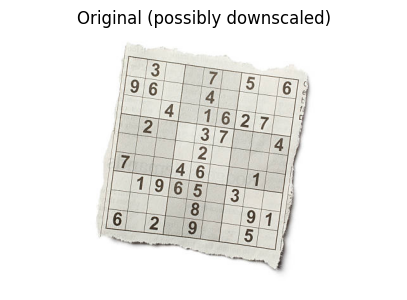

In [222]:


IMAGE_PATH = "sample/image4.jpg"


MAX_SIDE = 1600

img = cv2.imread(IMAGE_PATH)
assert img is not None, f"Could not read image at {IMAGE_PATH}. Please set IMAGE_PATH correctly."

h, w = img.shape[:2]
scale = min(1.0, MAX_SIDE / max(h, w))
if scale < 1.0:
    img = cv2.resize(img, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)

show(img, "Original (possibly downscaled)")


## 2) Preprocess 


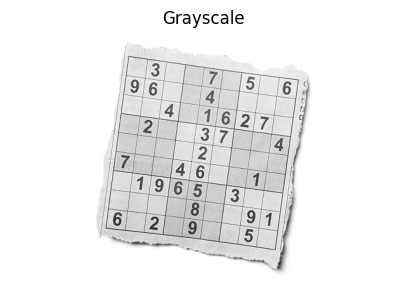

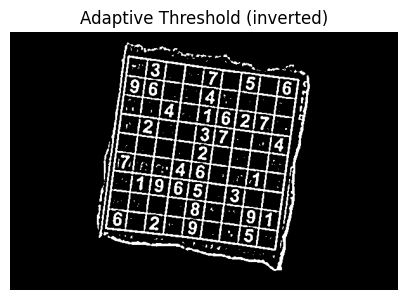

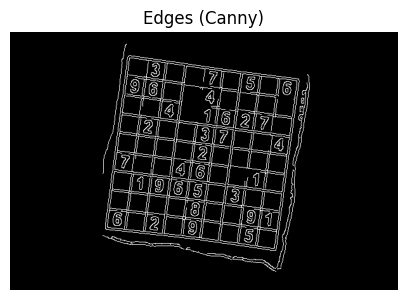

In [223]:

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (7,7), 0)

th = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                           cv2.THRESH_BINARY, 11, 2)
th_inv = cv2.bitwise_not(th)

edges = cv2.Canny(blur, 50, 150)

show(gray, "Grayscale")
show(th_inv, "Adaptive Threshold (inverted)")
show(edges, "Edges (Canny)")


## 3) Find the puzzle 


In [224]:

def order_points(pts):
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1).reshape(-1)
    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]
    tr = pts[np.argmin(diff)]
    bl = pts[np.argmax(diff)]
    return np.array([tl,tr,br,bl], dtype=np.float32)

def find_puzzle_corners(bin_img):
    contours, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    for cnt in contours:
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        if len(approx) == 4:
            pts = approx.reshape(4,2).astype(np.float32)
            return order_points(pts)
        
    cnt = contours[0]
    peri = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
    if len(approx) >= 4:
        pts = cv2.convexHull(approx).reshape(-1, 2).astype(np.float32)
        
        rect = cv2.minAreaRect(pts)
        box = cv2.boxPoints(rect)
        return order_points(box.astype(np.float32))
    return None

corners = find_puzzle_corners(th_inv)
assert corners is not None, "Could not find the puzzle boundary"
corners


array([[187.,  38.],
       [456.,  77.],
       [418., 345.],
       [150., 311.]], dtype=float32)

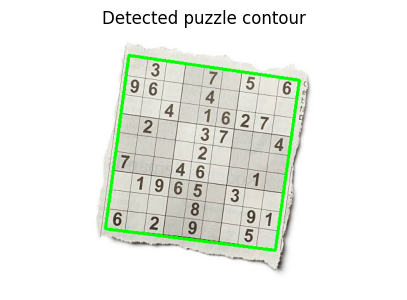

In [225]:

img_vis = img.copy()
cv2.polylines(img_vis, [corners.astype(int)], True, (0,255,0), 3)
show(img_vis, "Detected puzzle contour")


## 4) Perspective transform 


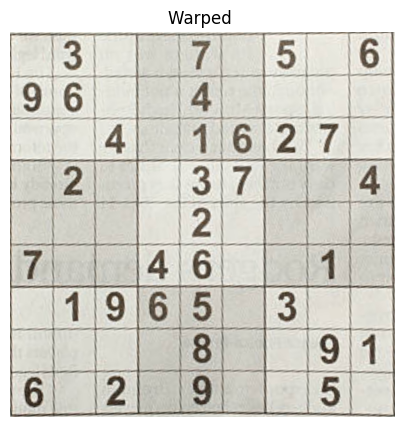

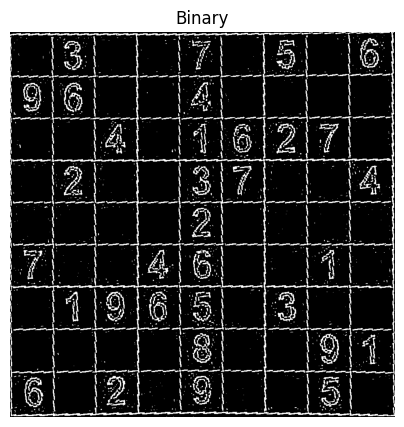

In [226]:

WARP_SIZE = 900  
dst = np.array([[0,0],[WARP_SIZE-1,0],[WARP_SIZE-1,WARP_SIZE-1],[0,WARP_SIZE-1]], dtype=np.float32)
M = cv2.getPerspectiveTransform(corners, dst)
warped = cv2.warpPerspective(img, M, (WARP_SIZE, WARP_SIZE))

warped_gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
warped_blur = cv2.GaussianBlur(warped_gray, (3,3), 0)
warped_th = cv2.adaptiveThreshold(warped_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv2.THRESH_BINARY, 5, 3)
warped_bin = cv2.bitwise_not(warped_th)

show(warped, "Warped ")
show(warped_bin, "Binary")


## 5) Grid overlay


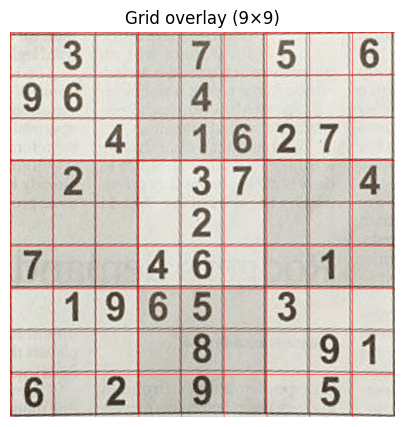

In [227]:

grid_vis = warped.copy()
cell_size = WARP_SIZE // 9
for i in range(10):
    y = i * cell_size
    cv2.line(grid_vis, (0,y), (WARP_SIZE,y), (0,0,255), 1, cv2.LINE_AA)
    x = i * cell_size
    cv2.line(grid_vis, (x,0), (x,WARP_SIZE), (0,0,255), 1, cv2.LINE_AA)
show(grid_vis, "Grid overlay (9×9)")


## 6) Extract digits from each cell


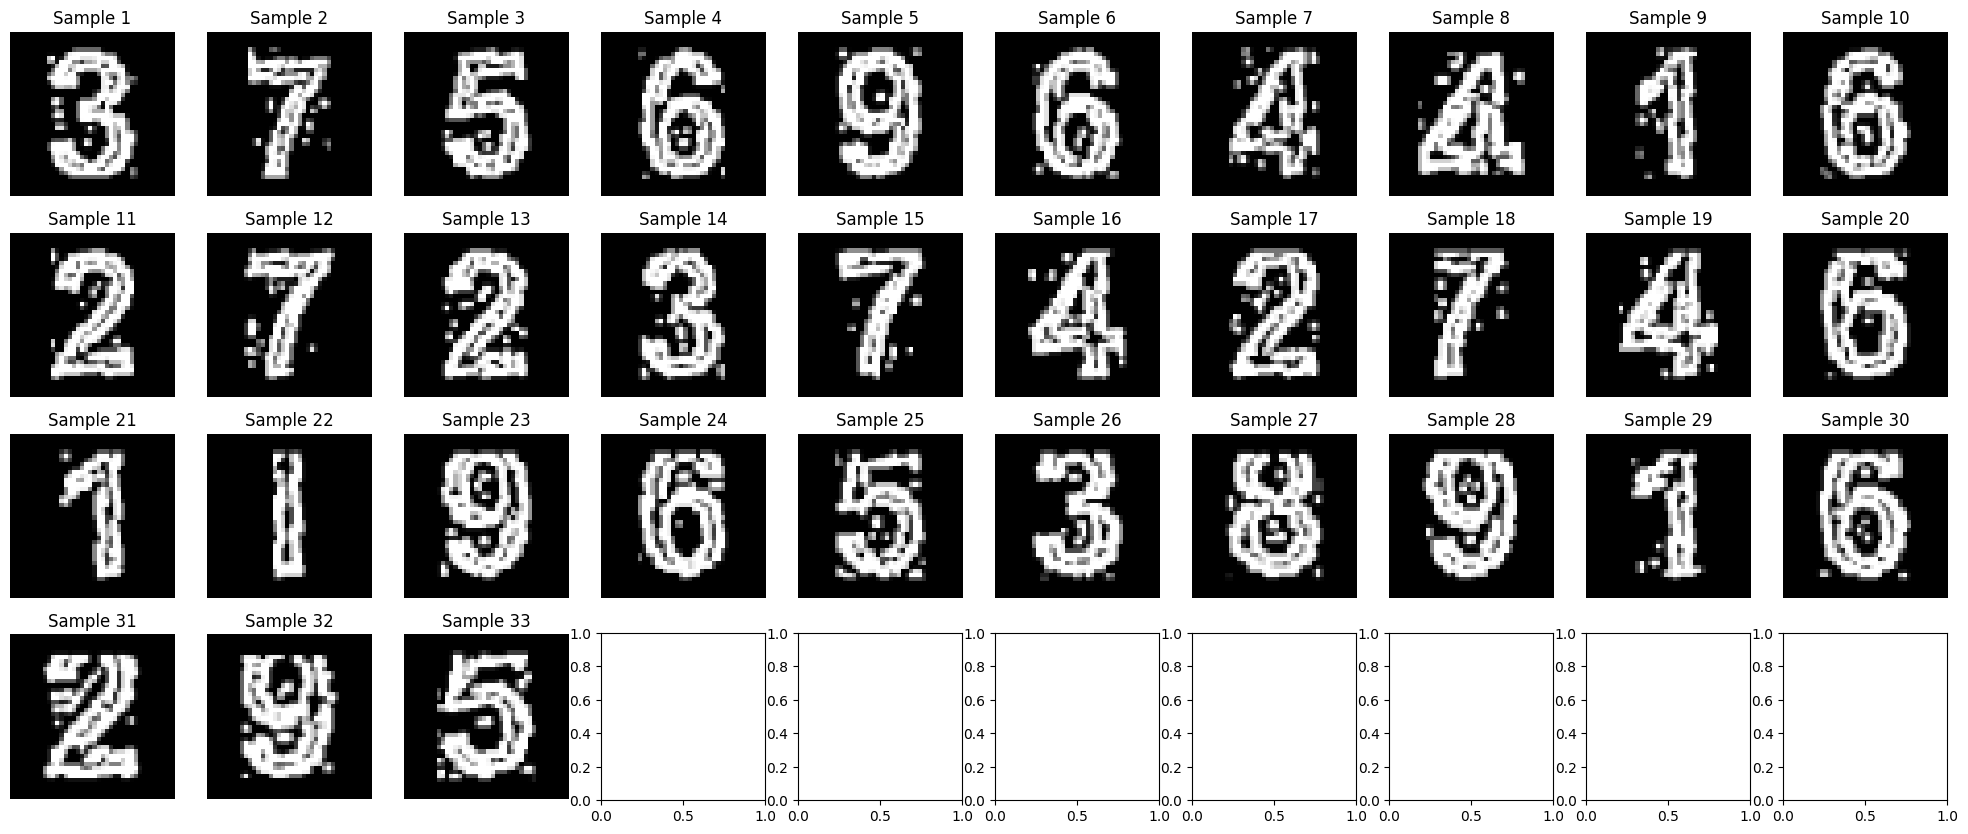

In [228]:

def largest_component_mask(bw):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(bw, connectivity=8)
    if num_labels <= 1:
        return None 
    
    areas = stats[1:, cv2.CC_STAT_AREA]
    idx = 1 + np.argmax(areas)
    mask = (labels == idx).astype(np.uint8) * 255
    return mask

def extract_digit_from_cell(cell_img, empty_threshold=0.08):
    g = cell_img.copy()
    g = cv2.GaussianBlur(g, (3,3), 0)
    g = cv2.morphologyEx(g, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
    # th = cv2.adaptiveThreshold(g, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    #                            cv2.THRESH_BINARY_INV, 11, 6)
    _, th = cv2.threshold(g, 0, 255, cv2.THRESH_BINARY_INV)
    bw = cv2.bitwise_not(th)  
    
    bw = cv2.morphologyEx(bw, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
    
    # # If very few foreground pixels, treat as empty
    frac = bw.sum() / 255.0 / bw.size
    if frac < empty_threshold:
        return None
    
    comp = largest_component_mask(bw)
    if comp is None:
        return None
    
    # Find bounding box of the largest component
    ys, xs = np.where(comp > 0)
    y0, y1 = ys.min(), ys.max()+1
    x0, x1 = xs.min(), xs.max()+1
    digit = bw[y0:y1, x0:x1]

    # Add padding and normalize to 40x40
    h, w = digit.shape
    side = max(h, w)
    canvas = np.zeros((side, side), dtype=np.uint8)
    y_off = (side - h)//2
    x_off = (side - w)//2
    canvas[y_off:y_off+h, x_off:x_off+w] = digit
    canvas = cv2.copyMakeBorder(canvas, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=(0,0,0))
    digit_norm = cv2.resize(canvas, (40,40), interpolation=cv2.INTER_AREA)
    return digit_norm

samples = []
pad = 13
for r in range(9):
    for c in range(9):
        y0, y1 = r*cell_size + pad, (r+1)*cell_size - pad
        x0, x1 = c*cell_size + pad, (c+1)*cell_size - pad
        cell = warped_bin[y0:y1, x0:x1]
        d = extract_digit_from_cell(cell)
        if d is not None:
            samples.append(d)

cols = 10
rows = ceil(len(samples) / cols)
from math import ceil
fig, ax = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))
ax = np.array(ax).reshape(-1)

for i, s in enumerate(samples):
    ax[i].imshow(s, cmap='gray')
    ax[i].set_title(f"Sample {i+1}")
    ax[i].axis('off')





## 7) Build Digit template 


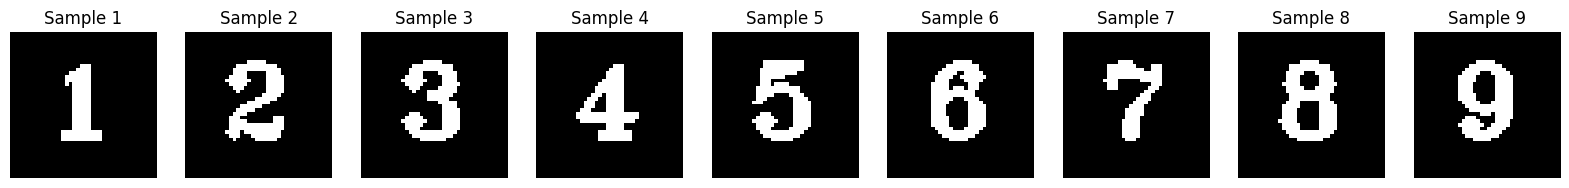

In [229]:

def render_digit_templates(size=40):
    templates = {d: [] for d in range(1,10)}
    fonts = [
        cv2.FONT_HERSHEY_DUPLEX,
        cv2.FONT_HERSHEY_TRIPLEX,
        cv2.FONT_HERSHEY_COMPLEX,
        cv2.FONT_HERSHEY_COMPLEX_SMALL
    ]
    scales = [0.9, 1.0, 1.1, 1.2]
    thicknesses = [1,2,3]
    for d in range(1,10):
        text = str(d)
        for f in fonts:
            for s in scales:
                for t in thicknesses:
                    canvas = np.zeros((size, size), dtype=np.uint8)
                    # get text size
                    (tw, th), _ = cv2.getTextSize(text, f, s, t)
                    x = (size - tw)//2
                    y = (size + th)//2 - 2
                    cv2.putText(canvas, text, (x,y), f, s, 255, t, cv2.LINE_AA)
                    # threshold to binarize
                    _, tmpl = cv2.threshold(canvas, 0, 255, cv2.THRESH_BINARY)
                    templates[d].append(tmpl)
    return templates

templates = render_digit_templates(size=40)
sum(len(v) for v in templates.values())

fig, ax = plt.subplots(1,9, figsize=(20, 5))
for i in range(9):
    tmpl = templates[i+1][12]  
    ax[i].imshow(tmpl, cmap='gray')
    ax[i].set_title(f"Sample {i+1}")
    ax[i].axis('off')



## 8) Recognize digits by template matching

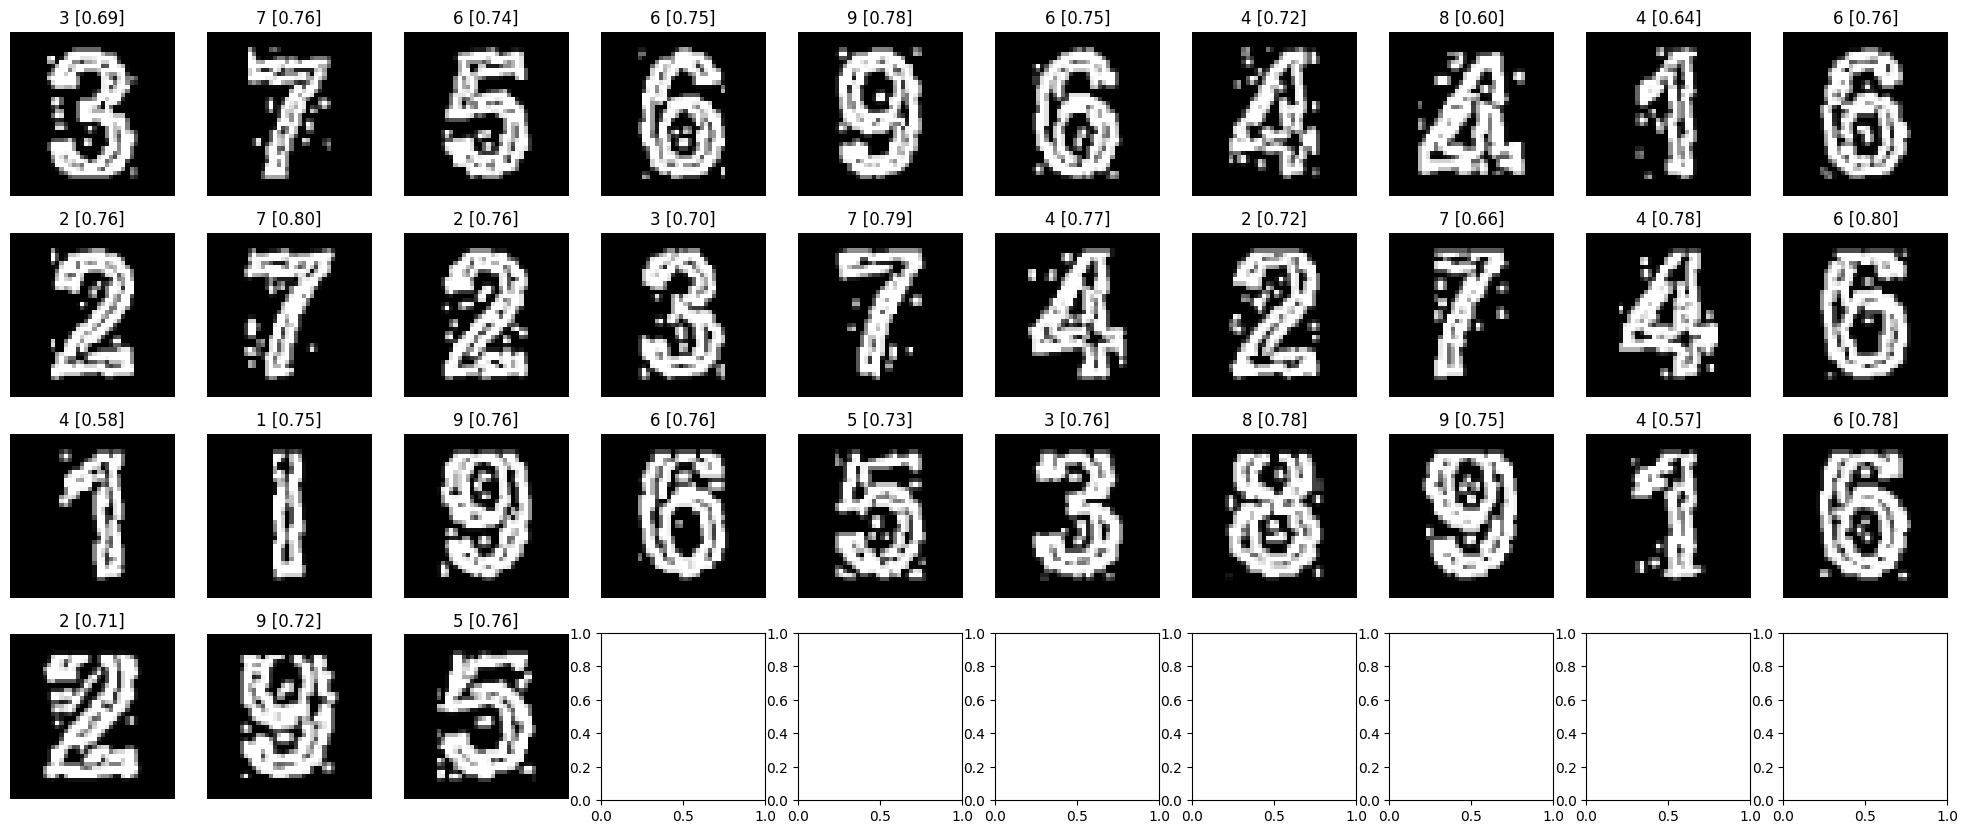

In [230]:

def recognize_digit(digit_img, templates, score_thresh=0.45):
    best_d = None
    best_score = -1.0
    # Ensure binary
    if digit_img.dtype != np.uint8:
        digit_img = digit_img.astype(np.uint8)
    for d, tmpls in templates.items():
        for tmpl in tmpls:
            res = cv2.matchTemplate(digit_img, tmpl, cv2.TM_CCOEFF_NORMED)
            score = float(res.max())
            if score > best_score:
                best_score = score
                best_d = d
    if best_score >= score_thresh:
        return best_d, best_score
    return None, best_score


fig, ax = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))
ax = np.array(ax).reshape(-1)

for i, s in enumerate(samples):
    d, sc = recognize_digit(s, templates)
    
    ax[i].imshow(s, cmap='gray')
    ax[i].set_title(f"{d} [{sc:.2f}]")
    ax[i].axis('off')



## 9) Extract the whole puzzle



In [231]:

grid = np.zeros((9,9), dtype=int)

pad = 13
for r in range(9):
    for c in range(9):
        y0, y1 = r*cell_size + pad, (r+1)*cell_size - pad
        x0, x1 = c*cell_size + pad, (c+1)*cell_size - pad
        cell = warped_bin[y0:y1, x0:x1]
        digit = extract_digit_from_cell(cell)
        if digit is None:
            grid[r, c] = 0
        else:
            val, score = recognize_digit(digit, templates)
            grid[r, c] = int(val) if val is not None else 0

grid


array([[0, 3, 0, 0, 7, 0, 6, 0, 6],
       [9, 6, 0, 0, 4, 0, 0, 0, 0],
       [0, 0, 8, 0, 4, 6, 2, 7, 0],
       [0, 2, 0, 0, 3, 7, 0, 0, 4],
       [0, 0, 0, 0, 2, 0, 0, 0, 0],
       [7, 0, 0, 4, 6, 0, 0, 4, 0],
       [0, 1, 9, 6, 5, 0, 3, 0, 0],
       [0, 0, 0, 0, 8, 0, 0, 9, 4],
       [6, 0, 2, 0, 9, 0, 0, 5, 0]])


## 10) Visualize extracted matrix over the rectified board


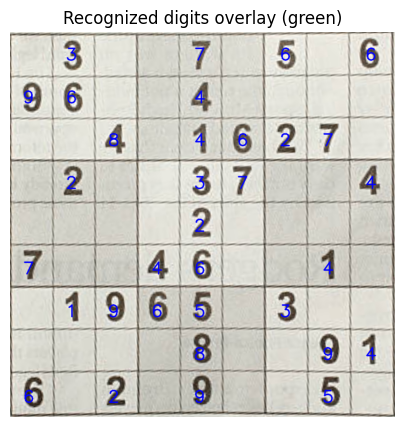

In [232]:

overlay = warped.copy()
for r in range(9):
    for c in range(9):
        val = grid[r,c]
        if val != 0:
            text = str(val)
            y = int((r+0.65)*cell_size)
            x = int((c+0.3)*cell_size)
            cv2.putText(overlay, text, (x,y), cv2.FONT_HERSHEY_SIMPLEX, 
                        1.3, (255,0,0), 2, cv2.LINE_AA)

show(overlay, "Recognized digits overlay (green)")

In [233]:
# save overlay image
output_path = Path(IMAGE_PATH).with_suffix('.overlay.png')
cv2.imwrite(str(output_path), overlay)
print(f"Overlay saved to {output_path}")

Overlay saved to sample\image4.overlay.png
